製作一個簡易的策略

短均超出長均時買

長均超出短均時賣


In [1]:
import pandas_datareader.data as web
from datetime import datetime

import pandas as pd
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

import talib

import matplotlib.pyplot as plt

In [2]:
#抓 TSLA 5 年資料
start = datetime(2018,1,1)
end = datetime(2023,2,7)
df = web.DataReader("TSLA",start,end)

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-31 00:00:00-05:00,164.570007,174.300003,162.779999,173.220001,173.220001,196813500
2023-02-01 00:00:00-05:00,173.889999,183.809998,169.929993,181.410004,181.410004,213806300
2023-02-02 00:00:00-05:00,187.330002,196.750000,182.610001,188.270004,188.270004,217448300
2023-02-03 00:00:00-05:00,183.949997,199.000000,183.690002,189.979996,189.979996,231684200
2023-02-06 00:00:00-05:00,193.009995,198.169998,189.919998,194.759995,194.759995,186188100


In [3]:
# 取開盤價、收盤價
close = df['Close']
Open = df['Open']

#ma1 = talib.SMA(close) # 日均線
ma5 = talib.SMA(close, timeperiod=5) # 5日均線
ma20 = talib.SMA(close, timeperiod=20) # 20日均線


In [4]:
# 抓出每天收盤價
CloseAll = close
OpenAll = Open

(array([17167.20833333, 17532.20833333, 17897.20833333, 18262.20833333,
        18628.20833333, 18993.20833333, 19358.20833333]),
 [Text(17167.208333333332, 0, '2017'),
  Text(17532.208333333332, 0, '2018'),
  Text(17897.208333333332, 0, '2019'),
  Text(18262.208333333332, 0, '2020'),
  Text(18628.208333333332, 0, '2021'),
  Text(18993.208333333332, 0, '2022'),
  Text(19358.208333333332, 0, '2023')])

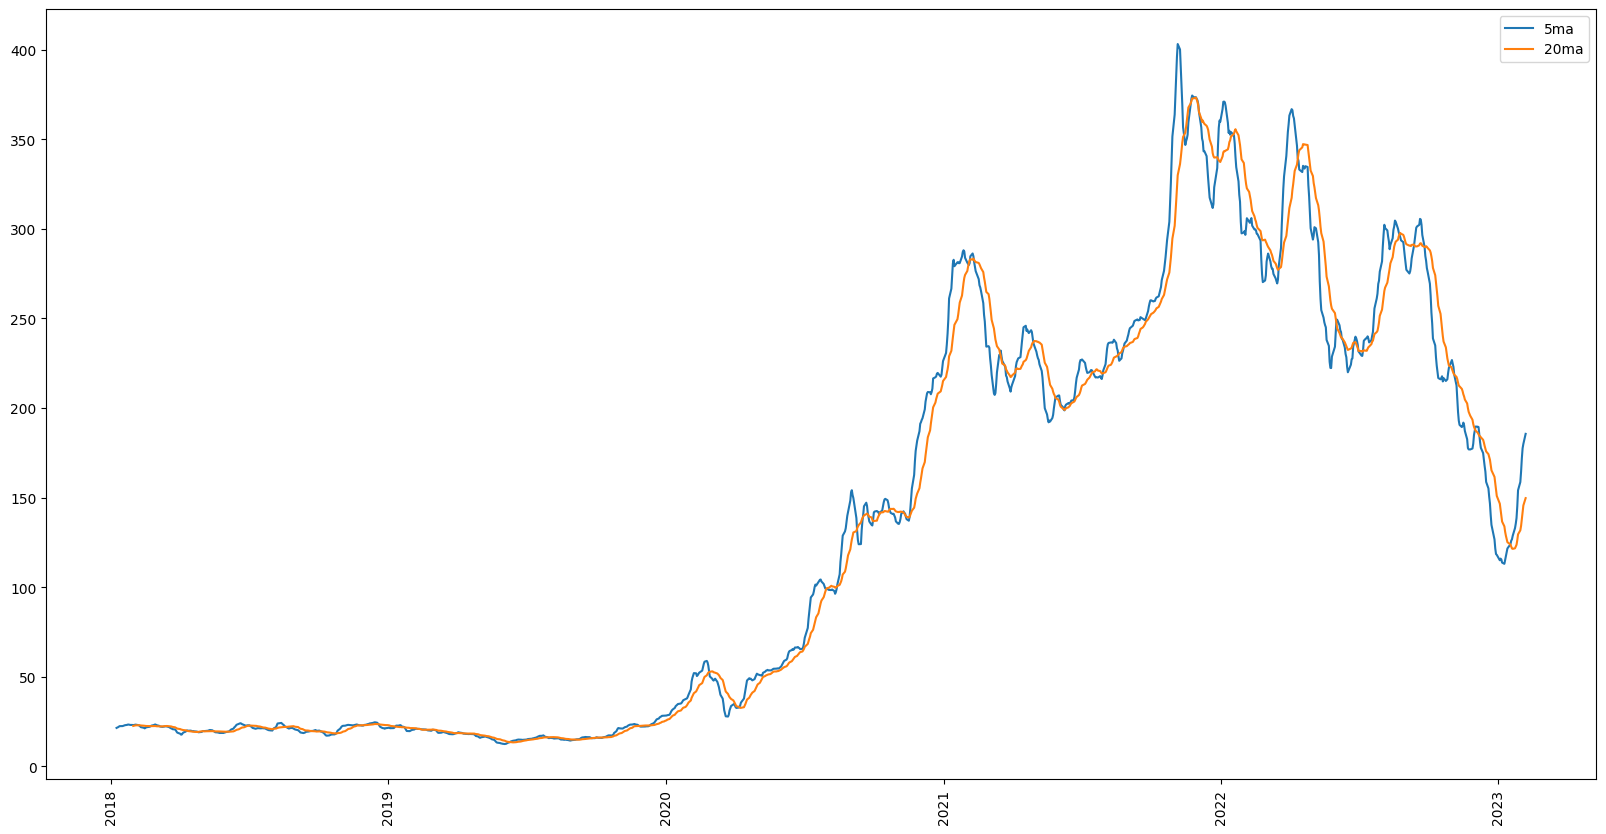

In [5]:
# 畫出均線圖

plt.figure(figsize=(20,10))
#plt.plot(ma1)
plt.plot(ma5)
plt.plot(ma20)
plt.legend(['5ma','20ma'])
plt.xticks(rotation='vertical')

從上圖可以看出，5ma與20ma有許多互相穿越的地方，這些就有可能會是買賣點。

找出訊號點

In [6]:
# 5ma與20ma差距
MA_dif = ma5 - ma20
#MA_dif = MA_dif['2019']

# 參數
stock = 0
sig = [] 

# 訊號
for i in range(len(MA_dif)):
    # 5MA往上穿越10MA
    if MA_dif[i-1] < 0 and MA_dif[i] > 0 and stock == 0:
        stock += 1
        sig.append(1)
    
    # 5MA往下穿越10MA
    elif MA_dif[i-1] > 0 and MA_dif[i] < 0 and stock == 1:
        stock -= 1
        sig.append(-1)
    else:
        sig.append(0)

# 製作dataframe
ma_sig = pd.Series(index = MA_dif.index, data = sig)
#ma_sig_2019 = ma_sig['2019']

In [7]:
# 每次買賣的報酬率
rets = []
transaction = []

# 是否仍有庫存
stock = 0
stock_his = []

# 當次交易買入價格
buy_price = 0

# 當次交易賣出價格
sell_price = 0

# 每次買賣的報酬率
#for i in range(len(ma_sig_2019)-1):
for i in range(len(ma_sig)-1):
    stock_his.append(stock)
    #if ma_sig_2019[i] == 1:
    if ma_sig[i] == 1:
        # 隔日開盤買入
        #buy_price = Open2019[ma_sig_2019.index[i+1]]
        buy_price = OpenAll[ma_sig.index[i+1]]
        stock += 1
        # 紀錄交易日期
        #transaction.append([ma_sig_2019.index[i+1],'buy'])
        transaction.append([ma_sig.index[i+1],'buy'])
    #elif ma_sig_2019[i] == -1:
    elif ma_sig[i] == -1:
        # 隔日開盤賣出
        #sell_price = Open2019[ma_sig_2019.index[i+1]]
        sell_price = OpenAll[ma_sig.index[i+1]]
        stock -= 1
        rets.append((sell_price-buy_price)/buy_price)
        # 賣出後就清空資料
        buy_price = 0
        sell_price = 0
        # 紀錄交易日期
        #transaction.append([ma_sig_2019.index[i+1],'sell'])
        transaction.append([ma_sig.index[i+1],'sell'])

# 如果最後手上有庫存，就用回測區間最後一天的開盤價賣掉
if stock == 1 and buy_price != 0 and sell_price == 0:
    #sell_price = Open2019[-1]
    sell_price = OpenAll[-1]
    rets.append((sell_price-buy_price)/buy_price)
    stock -= 1
    #transaction.append([Open2019.index[-1],'sell'])
    transaction.append([OpenAll.index[-1],'sell'])

# 總報酬率
total_ret = 1
for ret in rets:
    total_ret *= 1 + ret
# print(str(round((total_ret - 1)*100,2)) + '%')
print('總報酬率：' + str(round(100*(total_ret-1),2)) + '%')
transaction

總報酬率：971.65%


[[Timestamp('2018-02-23 00:00:00-0500', tz='America/New_York'), 'buy'],
 [Timestamp('2018-03-08 00:00:00-0500', tz='America/New_York'), 'sell'],
 [Timestamp('2018-04-12 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-04-27 00:00:00-0400', tz='America/New_York'), 'sell'],
 [Timestamp('2018-05-03 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-05-18 00:00:00-0400', tz='America/New_York'), 'sell'],
 [Timestamp('2018-06-05 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-07-05 00:00:00-0400', tz='America/New_York'), 'sell'],
 [Timestamp('2018-08-06 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-08-21 00:00:00-0400', tz='America/New_York'), 'sell'],
 [Timestamp('2018-09-24 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-10-05 00:00:00-0400', tz='America/New_York'), 'sell'],
 [Timestamp('2018-10-26 00:00:00-0400', tz='America/New_York'), 'buy'],
 [Timestamp('2018-11-27 00:00:00-0500', tz='America/New_Yo